# Detector Architecture Analysis

### Summary

| Model       | Parameters (approx.) | Inference Time (per image)  | Key Architectural Differences |
|-------------|----------------------|-----------------------------|-------------------------------|
| **YOLOv8**  | Low to moderate      | ~10–20 ms on GPU            | Single-stage, anchor-free design with efficient backbones (e.g., CSP variants). Emphasizes speed and real-time performance with optimized detection heads. |
| **RT-DETR** | Moderate to high     | ~30 ms on GPU (varies)      | Transformer-based detector that removes hand-crafted anchors. Uses an encoder–decoder transformer structure to directly model object relationships, aiming for real-time performance while benefiting from global context. |
| **Mask R-CNN** | High              | ~200+ ms on GPU             | Two-stage detector that extends Faster R-CNN by adding a branch for instance segmentation. Uses a Region Proposal Network (RPN) followed by ROI pooling and separate heads for classification, bounding box regression, and mask prediction. |

### Models Analysis

YOLOv8 stands out for its speed and efficiency, making it well-suited for applications where real-time detection is critical. Its architecture is optimized to maintain a relatively low parameter count while achieving high accuracy. In contrast, RT-DETR use transformer models to directly predict object detections without relying on pre-defined anchors. Although its parameter count might be higher, its real-time performance is achieved by smartly optimizing the transformer components. Mask R-CNN, on the other hand, takes a two-stage approach that not only detects objects but also segments them, which generally results in a higher number of parameters and slower inference times. However, its ability to provide pixel-level masks is invaluable for tasks requiring instance segmentation.




***PART2***

In [8]:
import os
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
import certifi, ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for detection confidence
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cpu"

predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get("coco_2017_train")

In [6]:
custom_image_dir = "./data/test_data"  
output_dir = "./custom_outputs"
os.makedirs(output_dir, exist_ok=True)

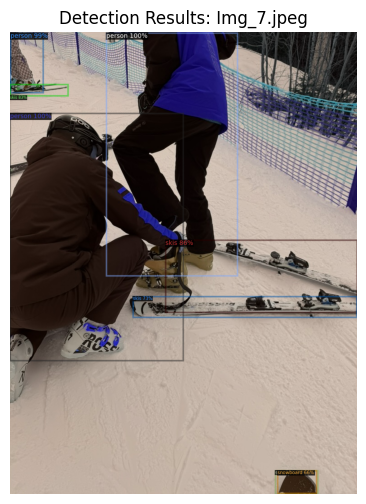

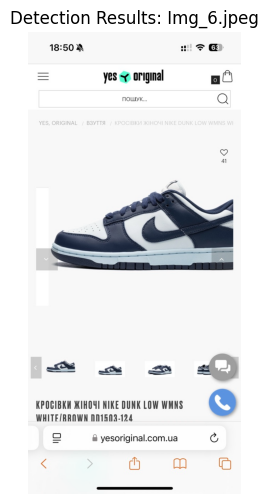

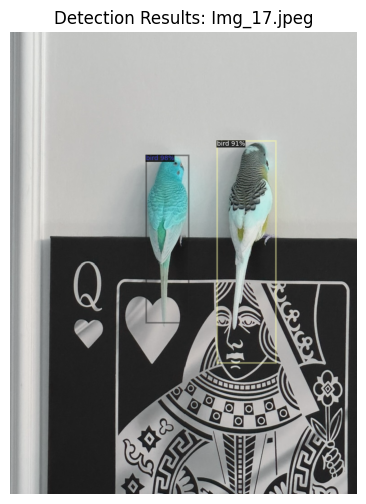

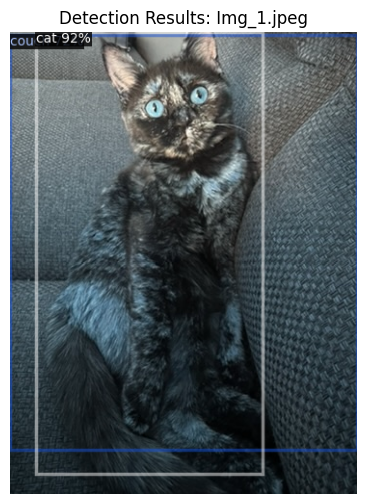

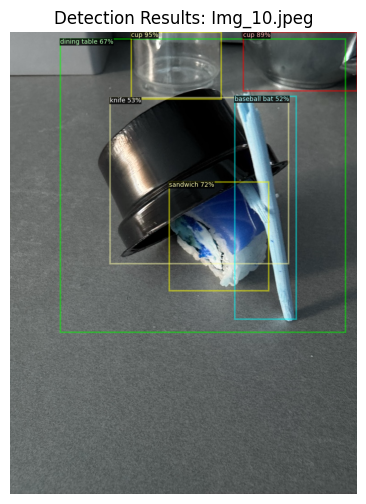

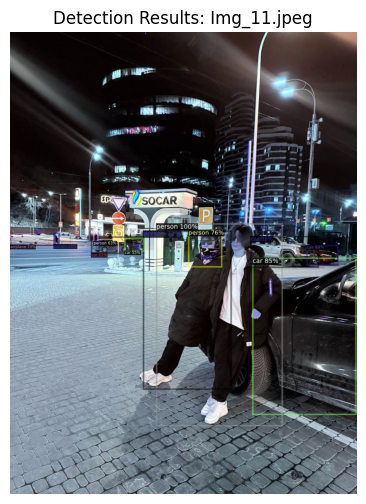

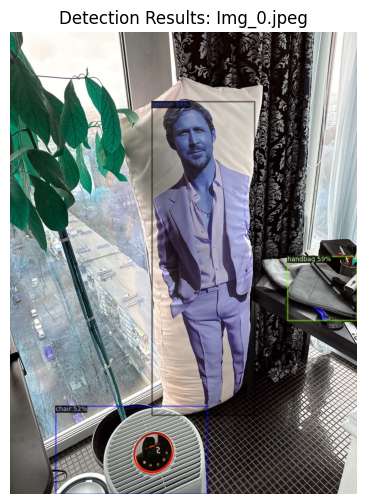

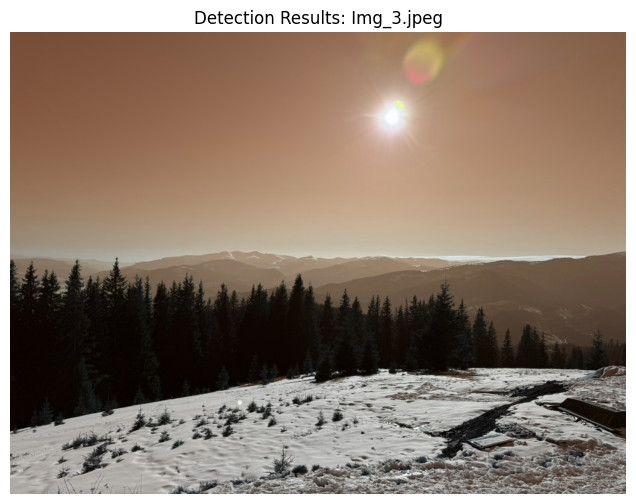

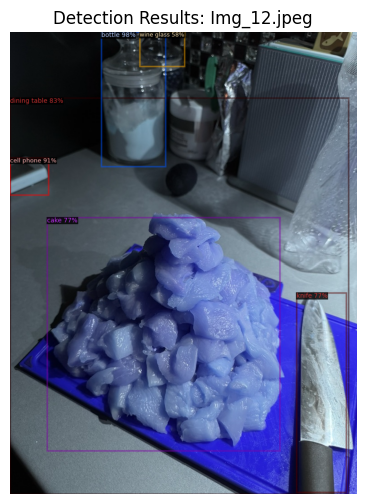

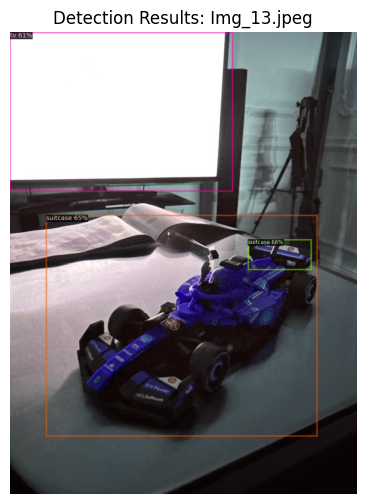

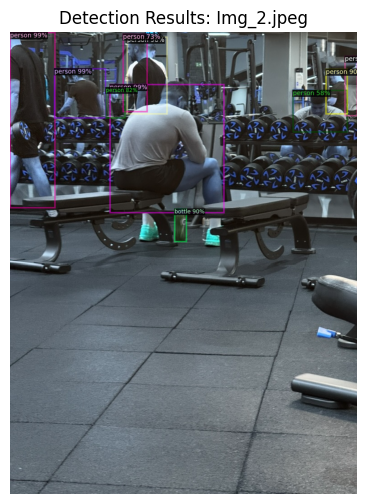

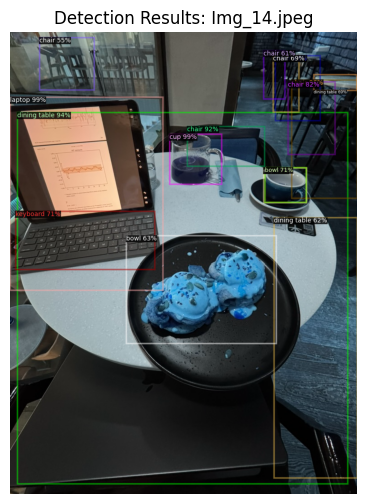

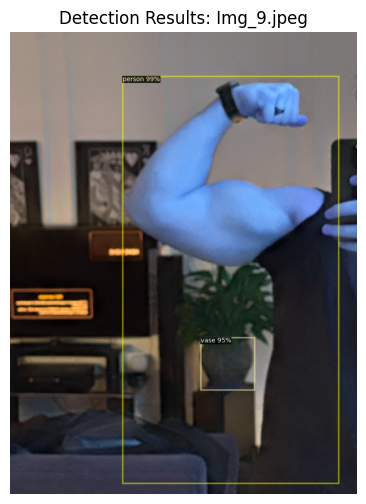

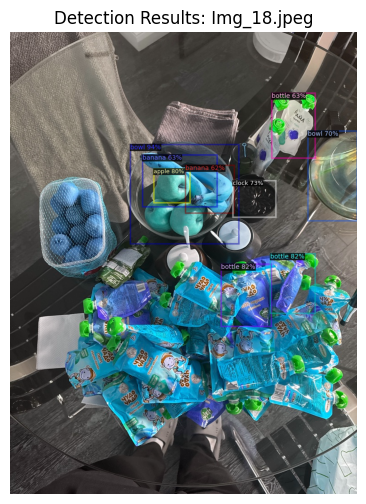

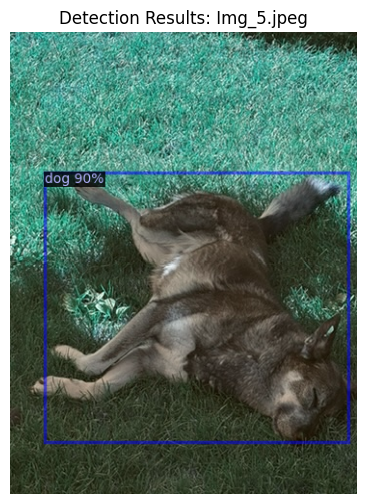

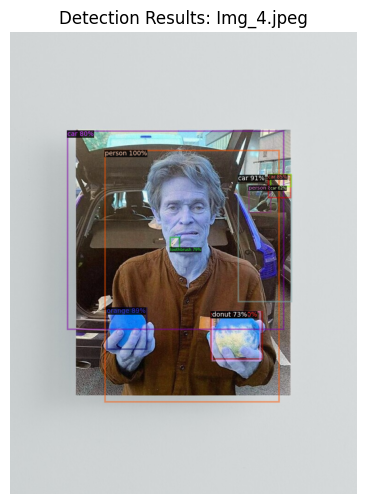

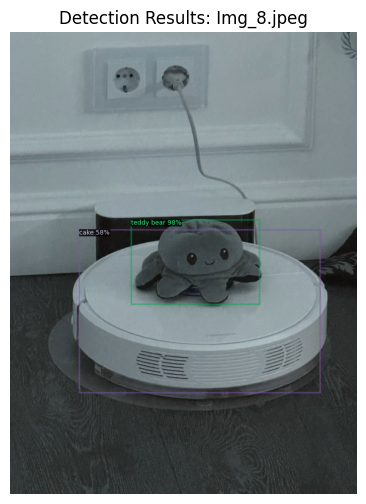

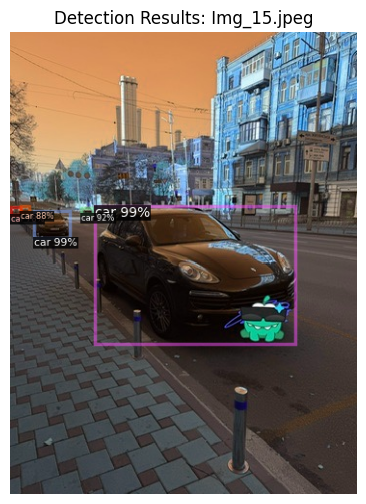

In [10]:
for image_name in os.listdir(custom_image_dir):
    image_path = os.path.join(custom_image_dir, image_name)
    image = cv2.imread(image_path)
    if image is None:
        continue  # skip files that are not readable as images
    
    outputs = predictor(image)
    
    # Pass the metadata to the Visualizer for labels to appear
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result_image = out.get_image()[:, :, ::-1]
    
    # Save the image with detections (boxes and labels)
    output_path = os.path.join(output_dir, image_name)
    cv2.imwrite(output_path, result_image)
    
    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(result_image)
    plt.title(f"Detection Results: {image_name}")
    plt.axis("off")
    plt.show()

For the real-world object detection task, I used Detectron2 with its pretrained models on a set of custom images captured under various conditions (different angles, scales, lighting conditions, and scene complexities). Overall, the model performed well in detecting objects in clear, well-lit images where objects were distinct and not heavily cluttered. The detection boxes and labels were accurate in most cases, particularly for objects with well-defined edges and consistent appearances.(Also there shouldn't be some random stuff, linda hard for NN to understadn meta-irony)

However, the results showed some limitations under challenging conditions. In images with low lighting or significant clutter, some objects were either missed or partially detected, and overlapping objects occasionally led to confusion in the predicted bounding boxes. These findings suggest that while the pretrained model offers robust performance out-of-the-box, further fine-tuning—especially using custom data that reflects these challenging conditions—could enhance detection accuracy. Additionally, employing data augmentation strategies (e.g., varying brightness and contrast) during fine-tuning might help mitigate errors related to lighting and occlusion.